split data in half (stratified) and perform grid-search on one half to determine random-forest parameters

In [1]:
import os, sys, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import randint
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import cross_val_score

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from config.feature_sets import get_linguistic_features, get_acoustic_features
from data_preparation.stratified_splits import create_and_save_stratified_folds
from regression.model_evaluation_helpers import load_task_dataframe, get_model_feature_list

# set file paths
demographics_path = os.path.join(GIT_DIRECTORY, "data/demographics_data.csv")
output_path = os.path.join(GIT_DIRECTORY, "data", "stratified_folds_grid_search.csv")
half_split_path = os.path.join(GIT_DIRECTORY, "data", "stratified_folds_grid_search.csv")
scores_path     = os.path.join(GIT_DIRECTORY, "data", "language_scores_all_subjects.csv")

# load data
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)

# parameters
task_name = "picnicScene"
target = "SemanticFluencyScore"
model_name = "full"
test_fold_label = 1  # held-out half
random_state = 42
n_iterations_random = 100 # randomized search iterations
refine_with_grid = True # if true: small grid around randomized-search-winner

# prepare demographics
for col in ["Gender","Education","Country"]:
    demographics[col] = demographics[col].astype("string").str.lower().str.strip()
demographics["Socioeconomic"] = pd.to_numeric(demographics["Socioeconomic"], errors="coerce")

demographics["Gender"] = demographics["Gender"].map({"f": 0, "m": 1})
education_map = {
    "less_than_highschool": 1,
    "high_school": 2,
    "vocational": 3,
    "bachelor": 4,
    "master": 5,
    "phd": 6,
    "no_answer": np.nan
}
demographics["Education"] = demographics["Education"].map(education_map)
demographics["Education_level"] = demographics["Education"].map({
    1: 0, # low
    2: 1, 3: 1, # medium
    4: 2, 5: 2, 6: 2 # high
})
demographics["Country"] = demographics["Country"].map({"uk": 0, "usa": 1})
demographics.drop(columns=["Language"], inplace=True, errors="ignore")


In [2]:
# split data in half (stratified)

# generate and save stratified folds
# create_and_save_stratified_folds(demographics_path=demographics_path, output_path=output_path, n_splits=2)

# load half split (n_splits=2)
half_df = pd.read_csv(half_split_path, dtype={"Subject_ID": str}).rename(columns={"fold":"half"})
half_df["Subject_ID"] = half_df["Subject_ID"].astype(str)


In [3]:
# set features
df_task = load_task_dataframe(task_name, target, scores, demographics)
df_task["Subject_ID"] = df_task["Subject_ID"].astype(str)

# merge split info
df = df_task.merge(half_df[["Subject_ID", "strat_group", "half"]], on="Subject_ID", how="inner")

linguistic_features = get_linguistic_features()
acoustic_features = get_acoustic_features()

demographic_cols = ["Age", "Gender", "Education_level", "Country", "Socioeconomic"]
model_configs = {
    "baseline": [],
    "demographics": demographic_cols,
    "linguistic": sorted(list(linguistic_features)),
    "acoustic": sorted(list(acoustic_features)),
    "linguistic+acoustic": sorted(list(linguistic_features | acoustic_features)),
    "full": sorted(list(linguistic_features | acoustic_features)) + demographic_cols
}

requested = model_configs[model_name]
feature_cols = get_model_feature_list(df.columns, requested, target)
df_use = df.dropna(subset=[target] + feature_cols).reset_index(drop=True)

picnicScene | full -> train N=493, test N=492, features=60
Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomizedSearch best params: {'bootstrap': False, 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 825}
RandomizedSearch best inner-CV R2: 0.189


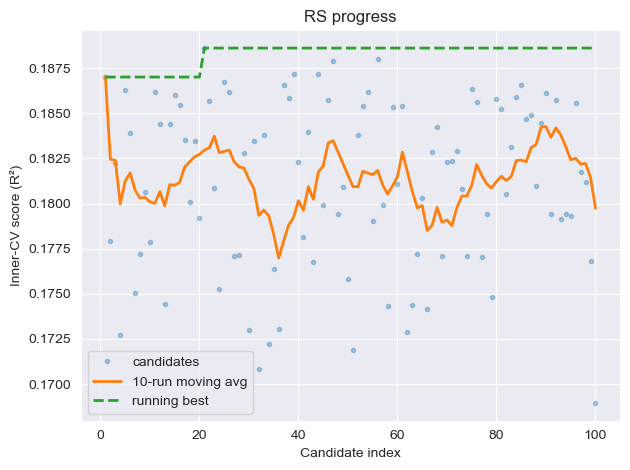

In [4]:
# split data (outer split -> 50% train, 50% test)

train_df = df_use[df_use["half"] != test_fold_label].reset_index(drop=True)
test_df  = df_use[df_use["half"] == test_fold_label].reset_index(drop=True)

X_train = train_df[feature_cols].apply(pd.to_numeric, errors="coerce")
y_train = train_df[target]
X_test  = test_df[feature_cols].apply(pd.to_numeric, errors="coerce")
y_test  = test_df[target]

# drop any remaining NaNs
tr_mask = X_train.notna().all(axis=1) & y_train.notna()
te_mask = X_test.notna().all(axis=1) & y_test.notna()
X_train, y_train = X_train.loc[tr_mask], y_train.loc[tr_mask]
X_test,  y_test  = X_test.loc[te_mask],  y_test.loc[te_mask]

print(f"{task_name} | {model_name} -> train N={len(X_train)}, test N={len(X_test)}, features={len(feature_cols)}")

# cross-validation (inner split -> 5-fold-cv on train-set)
inner_cv = list(KFold(n_splits=5, shuffle=True, random_state=random_state)
                .split(np.arange(len(X_train))))

# randomized search on train-half
# set range of possible parameters
param_dist = {
    "n_estimators": randint(100, 1001),
    "max_depth": [None] + list(range(10, 31)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 6),
    "bootstrap": [True, False]
}

rs = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=random_state, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=n_iterations_random,
    scoring="r2",
    cv=inner_cv,
    n_jobs=-1,
    verbose=2,
    random_state=random_state,
    refit=True,
    return_train_score=True
)
rs.fit(X_train, y_train)
best_params = rs.best_params_
best_cv = float(rs.best_score_)
print("RandomizedSearch best params:", best_params)
print("RandomizedSearch best inner-CV R2:", f"{best_cv:.3f}")


In [5]:
# refine with grid-search
if refine_with_grid:
    bp = rs.best_params_

    def win(center, radius, low, high, step=1):
        a = max(low, int(center) - radius)
        b = min(high, int(center) + radius)
        return list(range(a, b + 1, step)) if a <= b else [int(center)]

    n_estimators_step = 50

    grid = {
        "n_estimators": win(bp["n_estimators"], radius=200, low=100, high=1000, step=n_estimators_step),
        "max_depth": win(bp["max_depth"], radius=3, low=10, high=30, step=1),
        "max_features": ["sqrt", "log2"],
        "min_samples_split": win(bp["min_samples_split"], radius=1, low=2, high=10, step=1),
        "min_samples_leaf": win(bp["min_samples_leaf"], radius=1, low=1, high=5, step=1),
        "bootstrap": [True]
    }

    gs = GridSearchCV(
        estimator=RandomForestRegressor(random_state=random_state, n_jobs=-1),
        param_grid=grid,
        scoring="r2",
        cv=inner_cv,
        n_jobs=-1,
        verbose=2,
        refit=True,
        return_train_score=False
    )
    gs.fit(X_train, y_train)
    best_params = gs.best_params_
    best_cv     = float(gs.best_score_)
    print("GridSearch best params:", best_params)
    print("GridSearch best inner-CV R2:", f"{best_cv:.3f}")


Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
[CV] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=800; total time=   1.2s
[CV] END bootstrap=True, max_depth=29, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=408; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=660; total time=   1.1s
[CV] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=584; total time=   0.8s
[CV] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=584; total time=   0.9s
[CV] END bootstrap=False, max_depth=22, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=445; total time=   0.7s
[CV] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=661